In [2]:
import datetime
import os
import time
import pickle
import wandb
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.compat.v1 as tfc
import numpy as np

from PIL import Image,ImageOps
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
from keras import callbacks
from sklearn.decomposition import PCA
from wandb.keras import WandbCallback


#import model generators
import stefan_cnn_v1
import oliver_cnn_v1
import sequential_nn
import new_cnn_oliver

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)

try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))
tf.executing_eagerly()

Num GPUs Available:  1
Found GPU at: /device:GPU:0


True

## CONSTANTS

In [31]:
CHANNELS = 1 #1 for grayscale, 3 for RGB
IMG_SIZE = 64
#INPUT_SHAPE = [IMG_SIZE,int(IMG_SIZE/2),CHANNELS]
INPUT_SHAPE = [IMG_SIZE,IMG_SIZE,CHANNELS]

BATCH_SIZE = 256
EPOCHS = 300

ROT= 20


NAME = f"O_CNN{int(time.time())}"
SOURCE = "train_images/"
RES = f"train_images_res_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}/"

### TensorBoard + Callbacks

In [5]:
#wandb.tensorboard.patch(root_logdir="logs/")

In [7]:
#%load_ext tensorboard
#%tensorboard --logdir logs

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)

## Adjust CSV

In [8]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


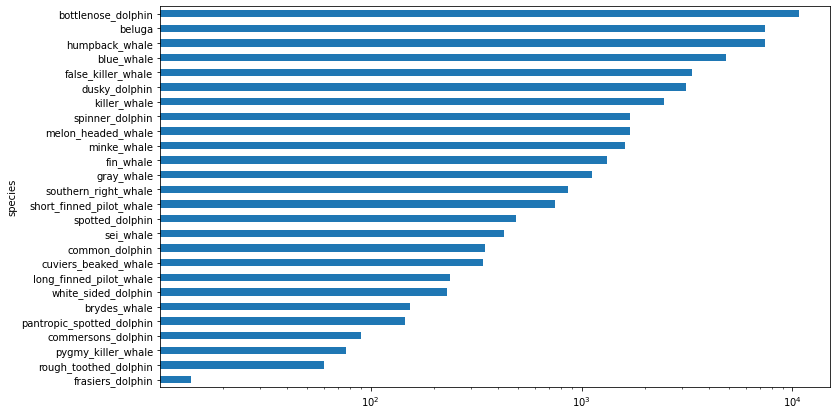

In [9]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [10]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
#train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)
#labels = train_df["species"]

##one-hot encode species
labels = pd.get_dummies(train_df.species, prefix='species_')
labels

,species__beluga,species__blue_whale,species__bottlenose_dolphin,species__brydes_whale,species__commersons_dolphin,species__common_dolphin,species__cuviers_beaked_whale,species__dusky_dolphin,species__false_killer_whale,species__fin_whale,...,species__minke_whale,species__pantropic_spotted_dolphin,species__pygmy_killer_whale,species__rough_toothed_dolphin,species__sei_whale,species__short_finned_pilot_whale,species__southern_right_whale,species__spinner_dolphin,species__spotted_dolphin,species__white_sided_dolphin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51028,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51029,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51030,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51031,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
AMT_CLASSES = labels.shape[1]

## Resize Images
This helps the model fitting --> picture preprocessing gets less intensive

In [12]:
if not os.path.exists(RES):
    os.mkdir(RES)
    for image in tqdm(images):
        savePath = RES + image  
        if not os.path.exists(savePath):
            imgPath = SOURCE + image
            im = Image.open(imgPath)
            im.thumbnail((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
            im = ImageOps.pad(im, (IMG_SIZE,IMG_SIZE), color='black')

            #resizedImage = im.resize((IMG_SIZE, IMG_SIZE), PIL.Image.ANTIALIAS)
            #resizedImage.save(savePath) 
            im.save(savePath)

In [13]:
full_img = list(map(RES.__add__, images))

## PCA

In [ ]:
img_array = []
for img in tqdm(full_img):
    im = np.array(Image.open(img).convert('L'))/255
    img_array.append(pd.Series(im.flatten(),name=img))
#img_array

In [93]:
pca = PCA(n_components=0.9)
pca_analyzed = pca.fit(img_array)

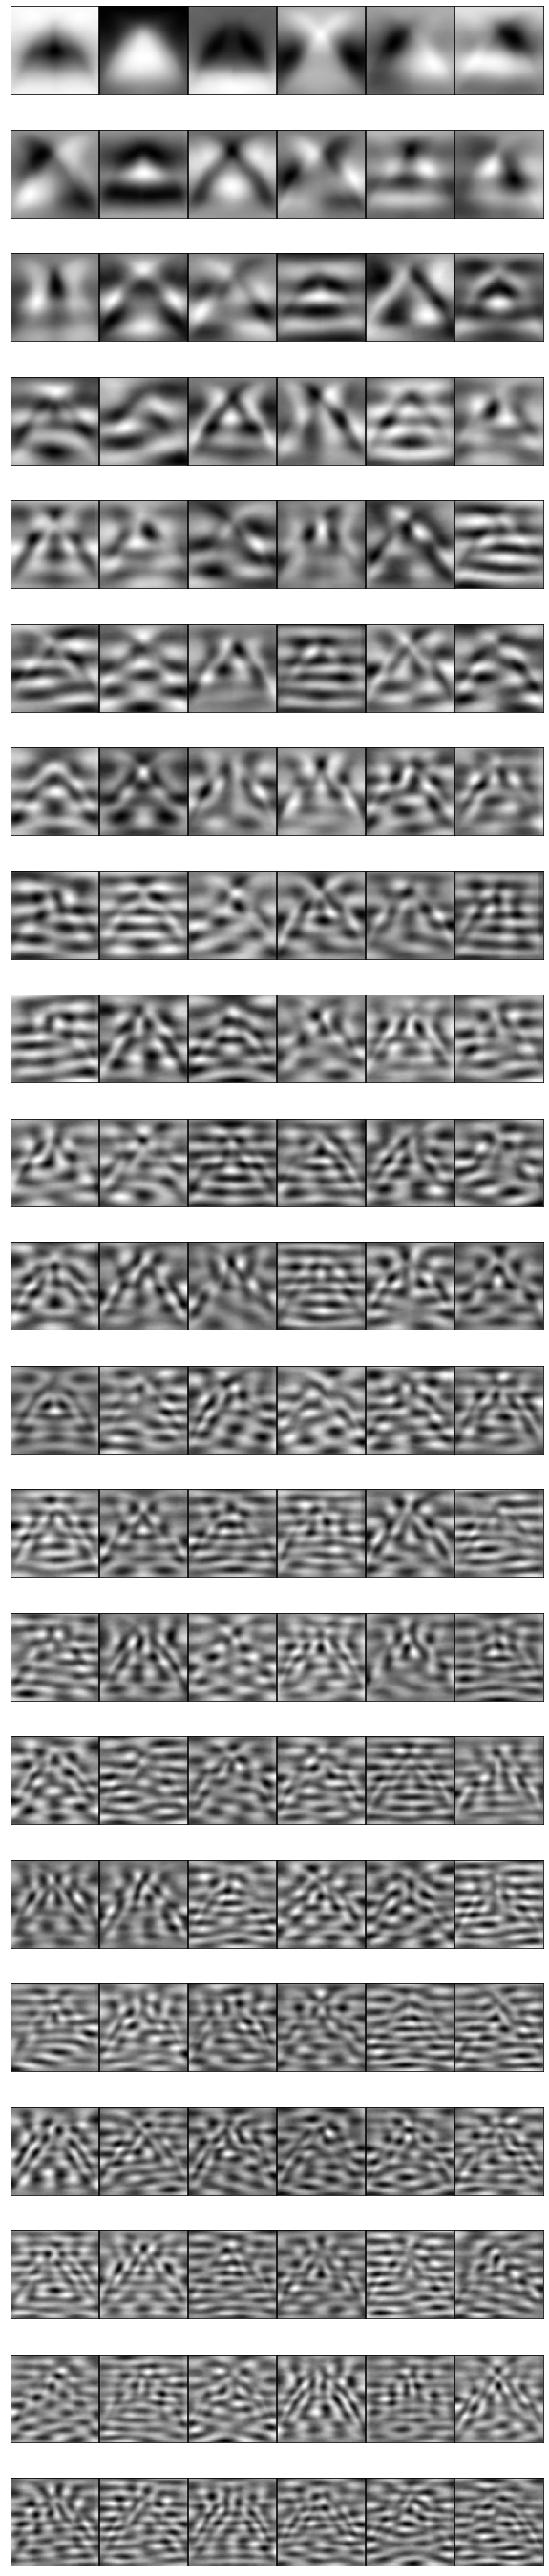

In [104]:
fig, axes = plt.subplots(21,6,figsize=(10,50),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca_analyzed.components_[i].reshape(INPUT_SHAPE),cmap="gray")

In [98]:
PCA_COMPONENTS = pca_analyzed.components_.shape[0]
print(PCA_COMPONENTS)

128


Text(0, 0.5, 'cum variance')

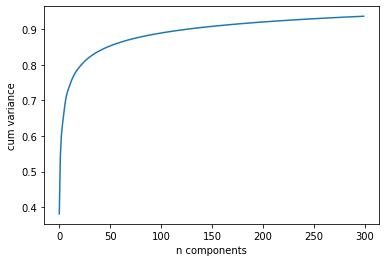

In [92]:
test_pca = PCA(300)
test_pca_analyzed = test_pca.fit(img_array)

Text(0, 0.5, 'cum variance')

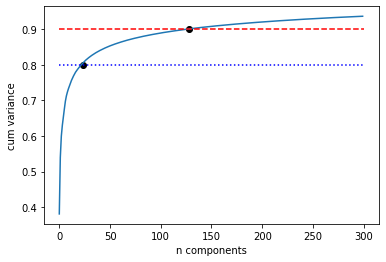

In [103]:
plt.plot(np.cumsum(test_pca_analyzed.explained_variance_ratio_))
plt.hlines(0.9,color="red",xmin=0, xmax=300, linestyle="dashed")
plt.hlines(0.8,color="blue",xmin=0, xmax=300, linestyle="dotted")
plt.scatter(128,0.9, color='black')
plt.scatter(23,0.8, color='black' )
plt.xlabel("n components")
plt.ylabel("cum variance")

#### Show first 3 PC

In [113]:
from mpl_toolkits.mplot3d import Axes3D
show_pca = PCA(3)
show_pca_analyzed = show_pca.fit(img_array)

X_pca = show_pca.transform(img_array) 

In [137]:
Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

<IPython.core.display.Javascript object>


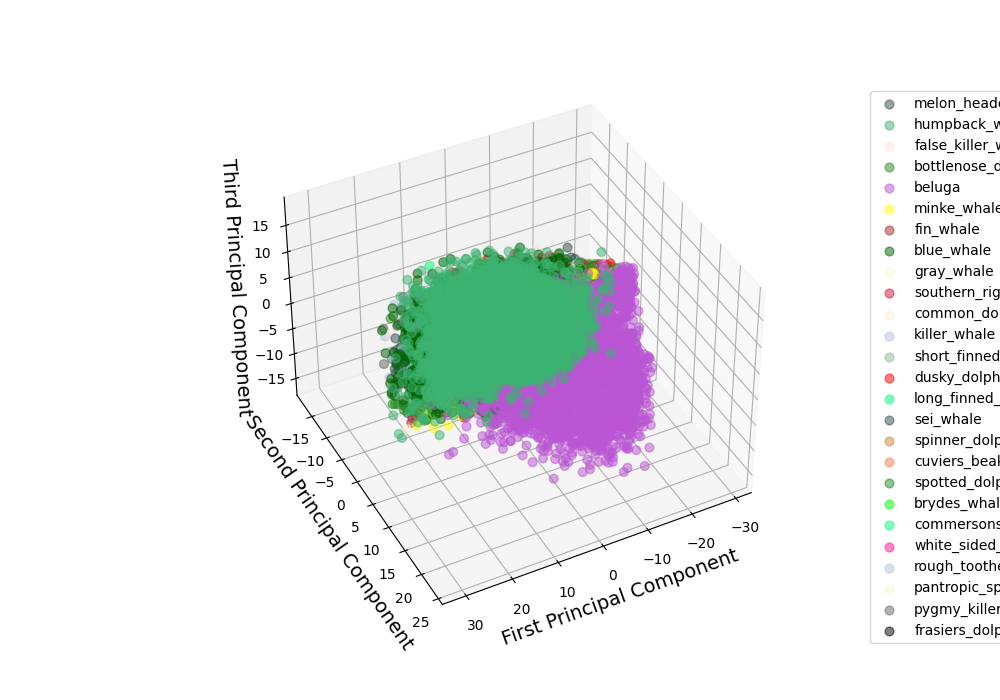

In [158]:
%matplotlib notebook
import matplotlib.colors as pltc
from random import sample
all_colors = [k for k,v in pltc.cnames.items()]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')

lbls = train_df.species.unique()
for i,l in enumerate(lbls):
    colors = sample(all_colors, len(lbls))
    ix=np.where(train_df.species==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=colors[i], s=40,label=lbls[i], alpha = 0.5)
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend(bbox_to_anchor=(1.15, 1.0),loc="upper left")
for angle in range(0, 360):
    ax.view_init(30, angle)
plt.show()

## Input Pipeline

In [105]:
@tf.function
def process_tuple(image,label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    

    
    img = tf.image.random_flip_left_right(img)
    
    lower,upper,size,max_delta = 0.1,0.3,0,0
    img = tf.image.random_contrast(img, lower, upper, seed=None)
    #img = tf.image.random_crop(img, size, seed=None, name=None)
    img = tf.image.random_brightness(img, max_delta, seed=None)
    
    #img = tf.keras.preprocessing.image.random_rotation(
        #img, ROT, row_axis=0, col_axis=1, channel_axis=2)
    
    img = tf.image.convert_image_dtype(img, tf.float16) / 255
    return img, label

def pca_transform(image,label):
    toast = image.numpy()[:, :, 0].flatten()[:,np.newaxis]
    toast = np.reshape(toast, (1,-1)) 
    pca_data = pca.transform(toast).flatten()
    return pca_data, label

@tf.function
def _adjust_shapes(pca_data, label):
    #ca_data = tf.convert_to_tensor(pca_data,dtype = tf.float16)
    #abel = tf.convert_to_tensor(label, dtype = tf.uint8)
    
    pca_data.set_shape(tf.TensorShape([PCA_COMPONENTS]))
    label.set_shape(tf.TensorShape([AMT_CLASSES]))
    return pca_data, label

In [106]:
dataset = tf.data.Dataset.from_tensor_slices((full_img, labels)).shuffle(1000).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).map(lambda x,y: tf.py_function(func=pca_transform,inp=[x,y],Tout=[tf.float16,tf.uint8])).map(_adjust_shapes,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [107]:
TRAIN_SPLIT = 0.7
VAL_TEST_SPLIT = (1-TRAIN_SPLIT)/2

image_count = dataset.cardinality().numpy()
train_size = int(image_count*TRAIN_SPLIT)
val_test_size = int(image_count*VAL_TEST_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_test_size)
test_ds = dataset.skip(train_size).skip(val_test_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_batched = val_ds.batch(batch_size=int(BATCH_SIZE*0.15)).cache().prefetch(tf.data.AUTOTUNE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### Benchmark Dataset

In [108]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [109]:
benchmark_ds = dataset.take(1)
#for d in benchmark_ds:
#    print(d)
benchmark(benchmark_ds)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]

Execution time: 0.29711200000019744


## Modelling

#### WandB

In [58]:
run = wandb.init(project="my-test-project",
           entity="dolphin_project",
           sync_tensorboard = True,
           config={
               "learning_rate": 0.005,
               "batch_size": BATCH_SIZE,
               "epochs": EPOCHS,
               "input_shape": INPUT_SHAPE,
               "loss_function": "categorical_crossentropy",
               "architecture": "CNN",
               "dataset": "dolphin",
               #"activation": ACTIVATION_STR,
               #"conv_units": [FIRST_CONV_UNITS, SECOND_CONV_UNITS] + CONV_UNITS_BODY,
           })
config = wandb.config

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


#### Model Keras

In [110]:
tf.keras.backend.clear_session()

ocnn = oliver_cnn_v1.create_model(INPUT_SHAPE, AMT_CLASSES)
scnn = stefan_cnn_v1.create_model(INPUT_SHAPE, AMT_CLASSES)
seqnn = sequential_nn.create_model(PCA_COMPONENTS, AMT_CLASSES)
nocnn = new_cnn_oliver.create_model(INPUT_SHAPE, AMT_CLASSES)
    
current_model = seqnn
    
current_model.summary()
current_model.compile(loss=config.loss_function,#tfa.losses.SigmoidFocalCrossEntropy()
             optimizer=keras.optimizers.Adam(config.learning_rate),
             metrics=['acc']) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential_2 (Sequential)   multiple                  0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256

In [111]:
history = current_model.fit(train_batched,
                   epochs = EPOCHS,
                   validation_data = val_batched,
                   callbacks=[WandbCallback(),
                              TensorBoard(log_dir=wandb.run.dir),
                              #WandbClassificationCallback(log_confusion_matrix=True, validation_data=val_batched, labels=list(range(AMT_CLASSES))),
                              earlystopping                           
                             ]
                )
wandb.watch(history)

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Epoch 1/300
140/140 [==============================] - ETA: 0s - loss: 2.5660 - acc: 0.2051

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


140/140 [==============================] - 303s 2s/step - loss: 2.5660 - acc: 0.2051 - val_loss: 2.5233 - val_acc: 0.2089
Epoch 2/300
140/140 [==============================] - 2s 12ms/step - loss: 2.5261 - acc: 0.2122 - val_loss: 2.5239 - val_acc: 0.2089
Epoch 3/300
140/140 [==============================] - 2s 11ms/step - loss: 2.5255 - acc: 0.2122 - val_loss: 2.5235 - val_acc: 0.2089
Epoch 4/300
140/140 [==============================] - 2s 11ms/step - loss: 2.5246 - acc: 0.2122 - val_loss: 2.5236 - val_acc: 0.2089
Epoch 5/300
140/140 [==============================] - 2s 12ms/step - loss: 2.5242 - acc: 0.2122 - val_loss: 2.5221 - val_acc: 0.2089
Epoch 6/300
140/140 [==============================] - 2s 11ms/step - loss: 2.5243 - acc: 0.2122 - val_loss: 2.5231 - val_acc: 0.2089
Epoch 7/300
140/140 [==============================] - 2s 13ms/step - loss: 2.5224 - acc: 0.2122 - val_loss: 2.5168 - val_acc: 0.2089
Epoch 8/300
140/140 [==============================] - 2s 12ms/step - loss

Error: wandb.watch only works with pytorch, couldn't import torch.

In [ ]:
cval = current_model.evaluate(test_batched, verbose = 0)


wandb.log({"test loss" : cval[0]})
wandb.log({"test acc" : cval[1]})
wandb.log({"test error rate" : round((1-cval[1])*100,2)})
run.finish()

In [25]:
print("test loss, test acc:", cval)

test loss, test acc: [1.452424168586731, 0.5572100281715393]


In [ ]:
with open(f'seqnn.pkl', 'wb') as file:
    pickle.dump(current_model,file)

In [ ]:
"""

#visualize model performance
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize=(15, 8))
ax1.plot(range(87), accuracy, "r", label="Training Accuracy")
ax1.plot(range(87), val_accuracy, "orange", label="Validation Accuracy")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc="lower left")

ax2.plot(range(87), loss, "b", label="Training Loss")
ax2.plot(range(87), val_loss, "g", label="Validation Loss")
ax2.grid(True)
ax2.legend(loc="lower left")
#plt.gca().set_ylim(0, 2)
"""